# PyTorch Basics Notebook
### Introduction to Tensors, Datasets, DataLoaders, CNNs, and U‑Net Building Blocks

## Import Required Libraries

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt


## PyTorch Tensors

In [15]:
# Creating tensors
x = torch.tensor([1.0, 2.0, 3.0])
y = torch.randn(3)  # random tensor

print(x)
print(y)

# Tensor operations
print('Addition:', x + y)
print('Mean:', x.mean())


tensor([1., 2., 3.])
tensor([ 1.7466, -0.2877,  0.9484])
Addition: tensor([2.7466, 1.7123, 3.9484])
Mean: tensor(2.)


## Autograd Basics

In [16]:
# Enable gradient tracking
a = torch.tensor([2.0, 3.0], requires_grad=True)
b = (a * a).sum()
b.backward()
print(a.grad)  # derivative of x^2 is 2x


tensor([4., 6.])


## Custom PyTorch Dataset

We simulate MRI-like slices using random arrays just for practice.

In [17]:
class RandomMRIDataset(Dataset):
    def __init__(self, length=100):
        self.length = length

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        image = torch.randn(1, 64, 64)      # fake MRI slice
        mask = (torch.randn(1, 64, 64) > 0).float()  # fake mask
        return image, mask

dataset = RandomMRIDataset()
img, msk = dataset[0]
img.shape, msk.shape


(torch.Size([1, 64, 64]), torch.Size([1, 64, 64]))

## DataLoader

In [18]:
loader = DataLoader(dataset, batch_size=8, shuffle=True)

for images, masks in loader:
    print(images.shape, masks.shape)
    break


torch.Size([8, 1, 64, 64]) torch.Size([8, 1, 64, 64])


## Building a Simple CNN

In [19]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32 * 16 * 16, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        return self.classifier(x)

model = SimpleCNN()
print(model)
print("Total parameters:",
      sum(p.numel() for p in model.parameters()))


SimpleCNN(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=8192, out_features=1, bias=True)
    (2): Sigmoid()
  )
)
Total parameters: 12993


## Training Loop Example

In [20]:
model = SimpleCNN()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(2):
    for images, masks in loader:
        optimizer.zero_grad()
        preds = model(images)
        loss = criterion(preds, torch.zeros_like(preds))  # dummy target
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch+1}, Loss: {loss.item():.4f}')


Epoch 1, Loss: 0.0000
Epoch 2, Loss: 0.0000


## U‑Net Building Blocks

In [21]:
def conv_block(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.ReLU(),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.ReLU()
    )

sample = torch.randn(1, 1, 128, 128)
block = conv_block(1, 16)
output = block(sample)
output.shape


torch.Size([1, 16, 128, 128])

## Exercises


1. Modify `RandomMRIDataset` to return a resized (128×128) slice using interpolation.  
2. Add another convolution layer to `SimpleCNN` and observe how the model size changes.  
3. Implement a small encoder-decoder network (mini U-Net) using `conv_block`.  
4. Write a custom Dice Loss function in PyTorch.  
5. Train the CNN on the random dataset and plot the loss curve using matplotlib.  


In [22]:
# Modified Dataset with interpolation
class RandomMRIDataset(Dataset):
    def __init__(self, length=100):
        self.length = length

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        image = torch.randn(1, 64, 64)      # fake MRI slice
        image = nn.functional.interpolate(image.unsqueeze(0), size=(128, 128), mode='bilinear', align_corners=False).squeeze(0)
        mask = (torch.randn(1, 64, 64) > 0).float()  # fake mask
        mask = nn.functional.interpolate(mask.unsqueeze(0), size=(128, 128), mode='nearest').squeeze(0)
        return image, mask

dataset = RandomMRIDataset()
img, msk = dataset[0]
img.shape, msk.shape

(torch.Size([1, 128, 128]), torch.Size([1, 128, 128]))

In [23]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 16 * 16, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        return self.classifier(x)

model = SimpleCNN()
print(model)

print("Total parameters:",
      sum(p.numel() for p in model.parameters()))

SimpleCNN(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=16384, out_features=1, bias=True)
    (2): Sigmoid()
  )
)
Total parameters: 39681


In [28]:
class miniUNet(nn.Module):
    def __init__(self):
        super().__init__()

        #Encoder
        self.en1 = conv_block(1, 16)
        self.en2 = conv_block(16, 32)
        self.pool = nn.MaxPool2d(2)

        #Bottleneck
        self.bottleneck = conv_block(32, 64)

        #Decoder
        self.up2 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)
        self.de2 = conv_block(64 + 32, 32)

        self.up1 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)
        self.de1 = conv_block(32 + 16, 16)

        #Output
        self.out_conv = nn.Conv2d(16, 1, 1)

    def forward(self, x):
        #Encoder
        e1 = self.en1(x)
        p1 = self.pool(e1)

        e2 = self.en2(p1)
        p2 = self.pool(e2)

        #Bottleneck
        b = self.bottleneck(p2)

        #Decoder
        u2 = self.up2(b)
        c2 = torch.cat([u2, e2], dim=1)
        d2 = self.de2(c2)

        u1 = self.up1(d2)
        c1 = torch.cat([u1, e1], dim=1)
        d1 = self.de1(c1)

        #Output
        out = self.out_conv(d1)
        return out

In [29]:
model = miniUNet()
x = torch.randn(1, 1, 128, 128)
y = model(x)
print(y.shape)

torch.Size([1, 1, 128, 128])


In [30]:
class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-6):
        super().__init__()
        self.smooth = smooth # smoothing factor to avoid division by zero, i mean it is just non zero tending to zero value

    def forward(self, preds, targets):
        preds = preds.view(-1)
        targets = targets.view(-1)
        intersection = (preds * targets).sum()
        dice = (2. * intersection + self.smooth) / (preds.sum() + targets.sum() + self.smooth)
        return 1 - dice

In [31]:
dataset_1 = RandomMRIDataset()
loader = DataLoader(dataset_1, batch_size=8, shuffle=True)

In [38]:
criterion = DiceLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 10
losses = []


for epoch in range(num_epochs):
    epoch_loss = 0.0

    for images, masks in loader:

        optimizer.zero_grad()

        outputs = torch.sigmoid(model(images))   # (B, 1, 128, 128 )
        loss = criterion(outputs, masks)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(loader)
    losses.append(avg_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

Epoch [1/10], Loss: 0.4957
Epoch [2/10], Loss: 0.4891
Epoch [3/10], Loss: 0.3843
Epoch [4/10], Loss: 0.3340
Epoch [5/10], Loss: 0.3337
Epoch [6/10], Loss: 0.3329
Epoch [7/10], Loss: 0.3318
Epoch [8/10], Loss: 0.3341
Epoch [9/10], Loss: 0.3338
Epoch [10/10], Loss: 0.3326


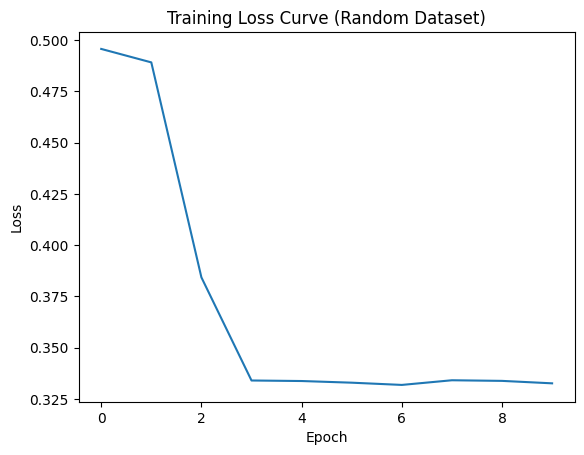

In [40]:
import matplotlib.pyplot as plt

plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Curve (Random Dataset)")
plt.show()